# Khám phá và tiền xử lý

## Cài đặt các thư viện cần thiết

In [732]:
# !pip install neattext
# !pip install wordcloud
# !pip install nltk

## Import các thư viện cần thiết

In [733]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from wordcloud import WordCloud
import neattext.functions as nfx
import nltk
from nltk.corpus import stopwords
import re

import neattext as nt

## Đọc dữ liệu từ file

In [734]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Hãy xem thử chúng ta đã đọc đúng dữ liệu chưa bằng cách in ra size và tên các cột

In [735]:
print('Train data shape:', train_df.shape)
print('Train columns:', train_df.columns)
print('Test data shape:', test_df.shape)
print('Test columns:', test_df.columns)

Train data shape: (7613, 5)
Train columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Test data shape: (3263, 4)
Test columns: Index(['id', 'keyword', 'location', 'text'], dtype='object')


## Tiền xử lý dữ liệu

### Xử lý các dữ liệu bị lặp

Chúng ta quan tâm đến những dòng trong cột "text" có dữ liệu bị lăp, những dòng lặp lại như thế này là không cần thiết khi xây dựng mô hình nên chúng ta cần loại bỏ nó, trước hết hãy cùng nhìn xem có bao nhiêu dòng như vậy.

In [736]:
print('Number of duplicated text on train data: ',train_df.duplicated(['text']).sum())
print('Number of duplicated text on test data: ',test_df.duplicated(['text']).sum())

Number of duplicated text on train data:  110
Number of duplicated text on test data:  20


Hãy nhìn rõ hơn những dòng đó có dữ liệu như thế nào

In [737]:
train_df[train_df['text'].duplicated() == True].sort_values(by=['text'])

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1


Ta nhận thấy rằng có môt số dòng có cùng text nhưng target khác nhau, việc này sẽ gây mâu thuẫn và dẫn đến dự đoán kết quả sai khi chạy mô hình. Việc chúng ta cần làm là đối với những dòng như vậy, chọn target theo số đông sau đó xem thử kết quả như thế nào.

In [738]:
train_df['target'] = train_df.groupby('text')['target'].transform(lambda x: x.mode().iat[0])
train_df[train_df['text'].duplicated() == True].sort_values(by=['text'])

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,0
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,0


Rất tốt, bây giờ với mỗi text thì chỉ có một target duy nhất, nhưng vẫn còn nhiều dòng có target trùng nhau, hãy drop các dòng đó để mỗi text chỉ lưu giữ 1 dòng duy nhất.

In [739]:
train_df = train_df.drop_duplicates(subset=['text'])
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


Bây giờ dữ liệu chỉ còn 7503 dòng so với ban đầu là 7613 dòng, ở phía trên ta cũng đã in ra và thấy được số dòng bị trùng lặp là 110, như vậy bây giờ dữ liệu đã không còn dòng nào có text bị lặp lại nữa. 

### Xử lý dữ liệu thiếu

Trước khi đi vào xử lý, hãy nhìn sơ qua dữ liệu chúng ta bị thiếu những gì. Dưới đây là hàm `missing_ratio(df)` trả về biểu đồ phần trăm dữ liệu thiếu của các cột có dữ liệu thiếu trong dataframe `df`

In [740]:
def missing_ratio(_df):
    missing_cols = _df.columns[_df.isnull().any()]
    plt.subplots(figsize=(6, 6))
    missing_ratio = _df[missing_cols].isnull().sum() * 100 / len(_df)
    missing_ratio.sort_values(inplace=True)
    missing_ratio.plot.bar(missing_ratio)
    return missing_ratio

Thử xem tập train có bao nhiêu dữ liệu thiếu

keyword      0.746368
location    33.080101
dtype: float64

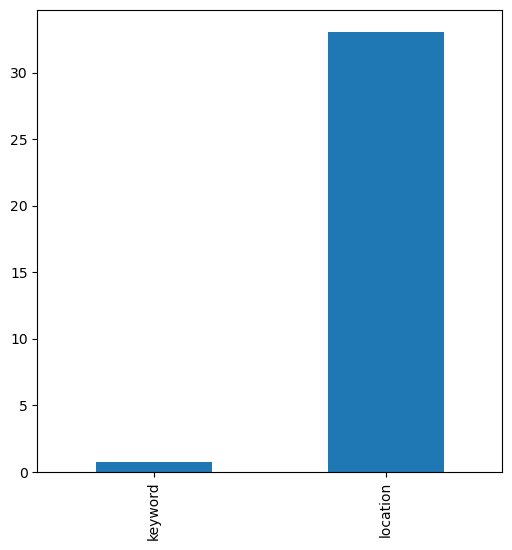

In [741]:
train_missing = missing_ratio(train_df)
train_missing

Thử xem tập test có bao nhiêu dữ liệu thiếu.

keyword      0.796813
location    33.864542
dtype: float64

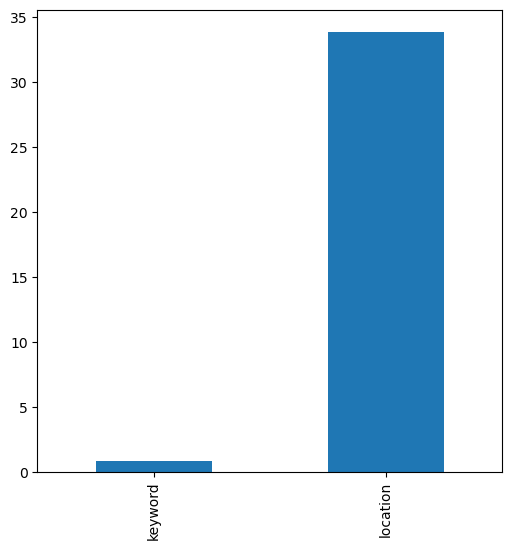

In [742]:
test_missing = missing_ratio(test_df)
test_missing

Bây giờ chúng ta sẽ thực hiện lấp đâỳ các giá trị trên bởi "None" để  không bị lỗi trong những xử lý sau này.

In [743]:
for col in ['keyword','location']:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

### Làm sạch cột `text`

Trong cột text, có những từ không cần thiết hoặc những ký tự không cần thiết có thể ảnh hưởng đến kết quả của quá trình chạy mô hình như mention, email, urls, emojis,... chúng ta cần thực hiện loại bỏ những thứ này để chuối "sạch" hơn và từ đó đạt kết quả tốt hơn.

In [744]:
def clean_text(text):
    text = re.sub(r"(?:\@)\S+", "", text) #Loại bỏ mention
    text = text.lower()
    docx = nt.TextFrame(text=text)
    docx.normalize()
    docx.remove_urls()
    docx.remove_emojis()
    docx.remove_emails()
    docx.remove_puncts()
    docx.remove_special_characters()
    docx.remove_numbers()
    docx.remove_stopwords()
    docx.fix_contractions()
    return docx.text

Thực hiện áp dụng hàm `clean_text()` vào tập train và tập text.

In [745]:
train_df['text']=train_df['text'].apply(lambda x: clean_text(x))
test_df['text']=test_df['text'].apply(lambda x: clean_text(x))

Bây giờ hãy nhìn xem các text trong tập train có dạng như thế nào.

In [746]:
train_df['text']

0                   deeds reason earthquake allah forgive
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7604    worldnews fallen powerlines glink tram update ...
7605        flip im walmart bomb evacuate stay tuned blow
7606    suicide bomber kills saudi security site mosqu...
7608    giant cranes holding bridge collapse nearby homes
7612    latest homes razed northern california wildfir...
Name: text, Length: 7503, dtype: object

Tương tự với tập test

In [747]:
test_df['text']

0                             happened terrible car crash
1             heard earthquake different cities stay safe
2         forest fire spot pond geese fleeing street save
3                   apocalypse lighting spokane wildfires
4                     typhoon soudelor kills china taiwan
                              ...                        
3258    earthquake safety los angeles safety fasteners...
3259    storm ri worse hurricane cityampothers hardest...
3260                        green line derailment chicago
3261             meg issues hazardous weather outlook hwo
3262    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

Tất cả đều nhìn có vẻ ổn, tuy nhiên phải check lại trong quá trình làm sạch chuối, có khi nào ta "làm sạch" đến mức mà chuỗi không còn gì hay không.

In [748]:
print(train_df[train_df['text'] ==""])
print(test_df[test_df['text'] ==""])

        id   keyword location text  target
4297  6103  hellfire     None            0
4891  6963  massacre     None            0
       id   keyword       location text
13     43      None           None     
632  2062  casualty  Canada | #LUX     


Rất tốt, không có chuỗi nào bị xóa hết thành chuỗi rỗng.

Số lượng cùng rất ít, chỉ có 2 dòng ở mỗi tập, vậy ta tiến hành drop luôn những dòng này

In [749]:
train_df = train_df[train_df['text'] !=""]
test_df = test_df[test_df['text'] !=""]

## Khám phá dữ liệu

### Khám phá cột target

Trước hết, chúng ta nhìn xem phân bố cột target là như thế nào.

In [750]:
count_target = train_df.groupby("target").count()
count_target = count_target.rename(columns={"text": "count"})
fig = px.bar(count_target, x=count_target.index, y='count')
fig.update_layout(xaxis={'type': 'category'}, title={
            'text': 'Target column distribution',
            'x': 0.5,  # Giữa trục x
            'xanchor': 'center',  # Căn giữa theo trục x
            'yanchor': 'top'  # Căn theo trục y
        })
fig.show()

Nhận xét: Số lượng các tweet không phải là thảm họa lớn hơn số tweet là thảm họa. Nếu lấy random 1 tweet, khả năng tweet đó không phải là thảm họa sẽ cao hơn.

### Khám phá cột keyword

Tiếp theo hãy nhìn xem các keyword liên quan như thế nào đối với target. Dưới đây là  biểu đồ trực quan top đầu và top cuối các key word được sắp xếp theo mean của target. Theo thứ tự từ trái sang phải là sự giảm dần của mean target, cột x là tên các keyword, cột y là số lượng của keyword đó.

In [751]:
top_key_word = train_df.groupby(["keyword"])["target"].mean().reset_index().sort_values(by = 'target', ascending=False)
top_key_word = top_key_word["keyword"]
#Chọn top 10 và 10 top cuôi
head_key_word = top_key_word.head(10)
tail_key_word = top_key_word.tail(10)

#Gom nhóm
target_by_keyword = train_df.groupby(["keyword", "target"])["text"].count().reset_index()
target_by_keyword = target_by_keyword.rename(columns={"text": "count"}) #SỐ lượng của text đặt tên là count
target_by_keyword['target'] = target_by_keyword['target'].astype(object)

from plotly.subplots import make_subplots


#Lọc ra và sắp xếp 
head_data = target_by_keyword[target_by_keyword["keyword"].isin(head_key_word)]
head_data = head_data.sort_values(by="keyword", key=lambda x: x.map({key: i for i, key in enumerate(head_key_word)}))

tail_data = target_by_keyword[target_by_keyword["keyword"].isin(tail_key_word)]
tail_data = tail_data.sort_values(by="keyword", key=lambda x: x.map({key: i for i, key in enumerate(tail_key_word)}))

color_map = {0: 'green', 1: 'red'}

#Tạo subplot
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 10 High Probability Keywords", "Top 10 Low Probability Keywords"))

# Top 10 high probability keywords
fig.add_trace(px.bar(head_data, x="keyword", y='count', color = "target", color_discrete_map=color_map).data[0], row=1, col=1)
fig.add_trace(px.bar(head_data, x="keyword", y='count', color = "target", color_discrete_map=color_map).data[1], row=1, col=1)

# Top 10 low  probability keywords
fig.add_trace(px.bar(tail_data, x="keyword", y='count', color = "target", color_discrete_map=color_map).data[0], row=1, col=2)
fig.add_trace(px.bar(tail_data, x="keyword", y='count', color = "target", color_discrete_map=color_map).data[1], row=1, col=2)

# Cột chồng
fig.update_layout(
    xaxis=dict(type='category'),
    showlegend=True,
    barmode='stack'
    
)

fig.update_traces(showlegend=True, row=1, col=1)  
fig.update_traces(showlegend=False, row=1, col=2)  


fig.show()

Nhận xét: 
- Kết quả dường như rất hợp lý khi các keyword `weckage`, `debris`, `derailment` có tỷ lệ disaster chiếm đến 100%, các keyword như `outbreak`, `oil%20spill`, `typhoon` cũng chiếm tỷ lệ khá cao
- Bên canh đó, một số  keyword như `ruin`, `body%20bags`, `aftershock` thì hầu như không phải là thảm họa. Nếu như gặp phải các keyword trên thì ta gần như nắm chắc phần tự tin trả lời target là bao nhiêu.

### Khám phá cột location

Hãy cùng nhìn xem địa điểm nào có nhiều tweet nhất.

In [752]:
top_location = train_df.groupby("location")["target"].count().sort_values(ascending=False).head(20)
top_location = top_location[top_location.index != "None"]

fig = px.bar(top_location, x=top_location.index, y=top_location.values)
fig.update_layout(xaxis={'type': 'category'}, 
                yaxis_title = "Count",
                xaxis_title = "Location",
                title={
                    'text': 'Top 20 location with the most tweets',
                    'x': 0.5,  # Giữa trục x
                    'xanchor': 'center',  # Căn giữa theo trục x
                    'yanchor': 'top'  # Căn theo trục y
                })


fig.show()



Nhận xét:
- Rất nhiều tweet được viết ở Mỹ (USA) và các thành phố, tiểu bang ở Mỹ
- Ngoài ra còn rất nhiều nơi khác, tóm lại là rất đa dạng.

Biểu đồ sẽ dễ so sánh giữa các địa phương, tuy nhiên muốn đếm số lượng tweet của nơi nào đó thì xem bảng dưới đây sẽ dễ hơn.

In [753]:
top_location

location
USA                104
New York            71
United States       50
London              45
Canada              29
Los Angeles, CA     26
UK                  26
Nigeria             23
India               21
Washington, DC      21
Mumbai              20
Kenya               20
Worldwide           19
Chicago, IL         18
Australia           18
California          17
California, USA     15
New York, NY        15
Everywhere          15
Name: target, dtype: int64

Nhận xét: Có một số địa điểm vốn là giống nhau nhưng lại chia thành 2 tên khác nhau như USA, United States... Chúng ta cần gộp những địa điểm này lại thành 1. Vì số lượng quá nhiều nên chúng tôi chỉ xử lý những địa điểm nổi bật, còn lại sẽ gộp chung thành địa điểm "Others"

In [754]:
def clean_location(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x or 'NY' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Kenya' in x:
        return 'Kenya'
    elif x in top_location.index:
        return x
    else: return 'Others'
    
train_df['location'] = train_df['location'].apply(lambda x: clean_location(str(x)))
test_df['location'] = test_df['location'].apply(lambda x: clean_location(str(x)))

/tmp/ipykernel_9511/4015617605.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Sau khi làm sạch tên các địa điểm, hãy cùng nhìn lại xem tỷ lệ tweet là thảm họa ở mỗi địa phương ở trên. Dưới đây là biểu đồ cột thể hiện tỷ lệ một tweet là thảm họa ở các địa phương khác nhau, đường gạch ngang nét đứt màu đỏ là đường tham chiếu thể hiện tỷ lệ thảm họa trung bình của tweet trên toàn tập dữ liệu.

In [755]:
#Lọc dữ liệu
location_df = train_df[train_df["location"].isin(top_location.index)]
location_target = location_df.groupby("location")["target"].mean().sort_values(ascending=False)
mean_target = train_df["target"].mean()

fig = go.Figure()
#Biểu đồ cột
fig.add_trace(go.Bar(
    x=location_target.index,
    y=location_target.values,
))
#Thêm đường tham chiếu
fig.add_shape(
    type="line",
    x0=-0.5,
    y0=mean_target,
    x1=len(location_target) - 0.5,
    y1=mean_target,
    line=dict(
        color="red",
        width=2,
        dash="dash"
    )
)
#Chỉnh các tiêu đề
fig.update_layout(
    xaxis={'type': 'category'},
    yaxis_title="Target",
    xaxis_title="Location",
    title={
        'text': 'Mean target of locations with the most tweets',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

Nhận xét: 
- Mumbai có tỷ lệ tweet là thảm họa cao đến dọa người, lớn hơn 0.8 và cao gấp đôi so với tỷ lệ trung bình. Tức là hầu như tweet nào ở đây trong tập dữ liệu cũng là nói về thảm họa. Các nơi như Nigeria, India cũng cao không kém
- Ba thành phố xếp cuối là London, Kenya, New York có tỷ lệ dưới trung bình tuy nhiên cũng không dưới nhiều quá mà cũng gần đường tham chiếu.

### Khám phá cột text

Trước hết, cùng nhìn xem phân bố độ dài của cột text.

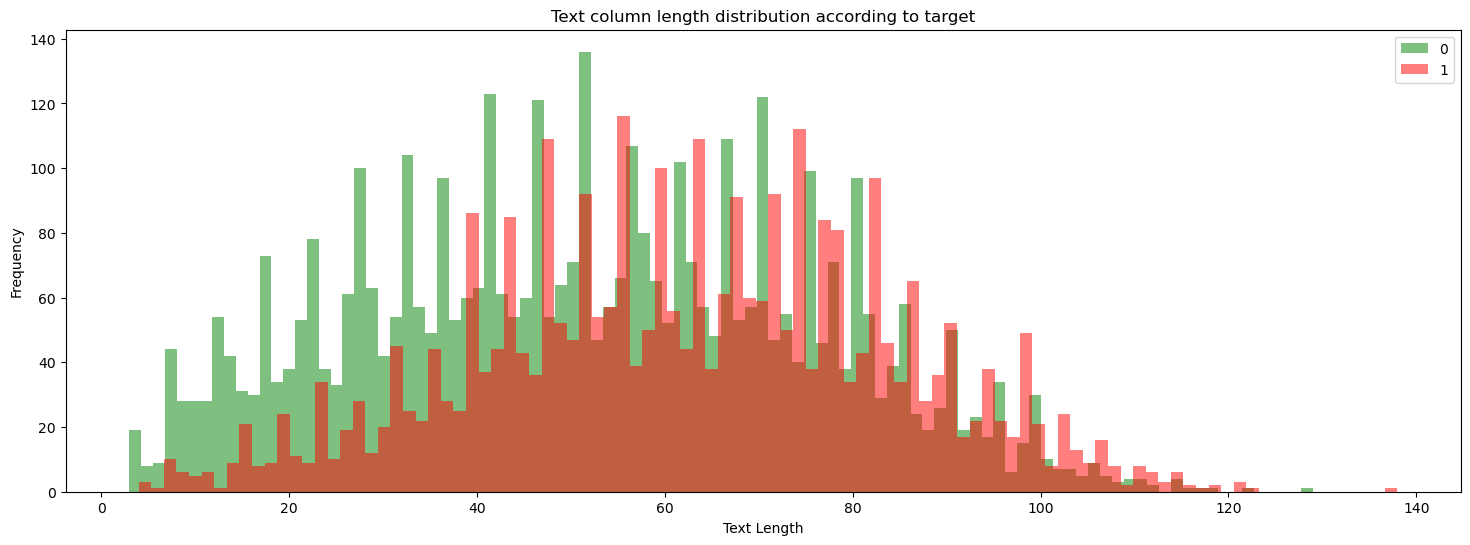

In [756]:
df_with_text_length = train_df.copy()
df_with_text_length['text_length'] = df_with_text_length['text'].apply(len)


# Tách dữ liệu cho mỗi target
target_0 = df_with_text_length[df_with_text_length['target'] == 0]['text_length']
target_1 = df_with_text_length[df_with_text_length['target'] == 1]['text_length']

# Vẽ histogram
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.hist(target_0, bins=100, alpha=0.5, label='0', color = "green")
plt.hist(target_1, bins=100, alpha=0.5, label='1', color = "red")

# Đặt tên trục và tiêu đề
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title("Text column length distribution according to target")

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()



Nhìn chung, các tweet có độ dài dưới 60 thì có khả năng cao hơn là một tweet không phải thảm họa

Số lượng từ trong mỗi câu phân bố như thế nào? Dưới đây là displot để trực quan.

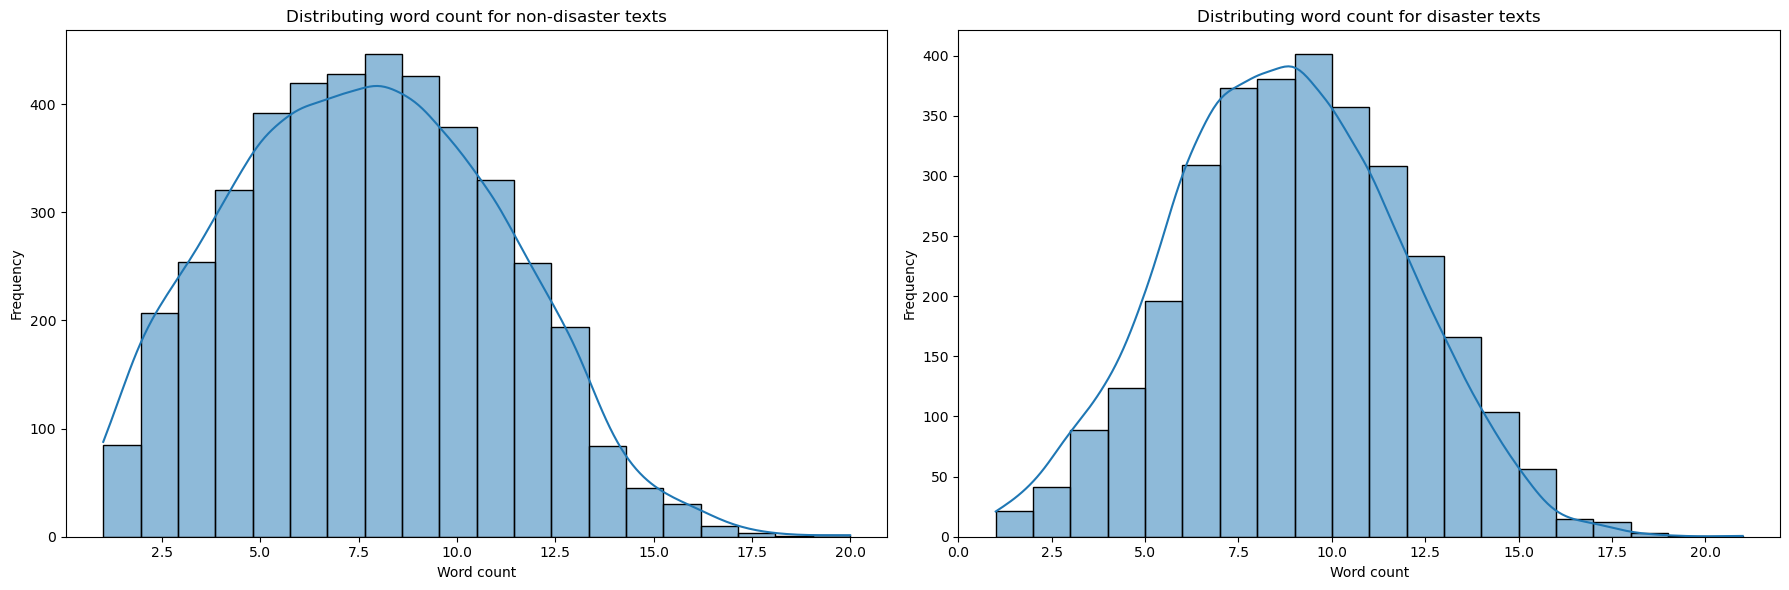

In [757]:
#Lọc dữ liệu
df_with_word_count = train_df.copy()
df_with_word_count['word_count'] = train_df['text'].str.split().map(lambda x: len(x))

#Vẽ biểu đồ cho target =  0
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data=df_with_word_count[df_with_word_count['target'] == 0], x='word_count', bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distributing word count for non-disaster texts')
axes[0].set_xlabel('Word count')
axes[0].set_ylabel('Frequency')

sns.histplot(data=df_with_word_count[df_with_word_count['target'] == 1], x='word_count', bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distributing word count for disaster texts')
axes[1].set_xlabel('Word count')
axes[1].set_ylabel('Frequency')

# Hiển thị biểu đồ
plt.tight_layout()

plt.show()

Các tweet có số từ dưới 7 từ có khả năng cao hơn là một tweet không thảm họa.

Đâu là các từ phổ biến trong một tweet? Hãy dùng wordcloud để trực quan điều này.

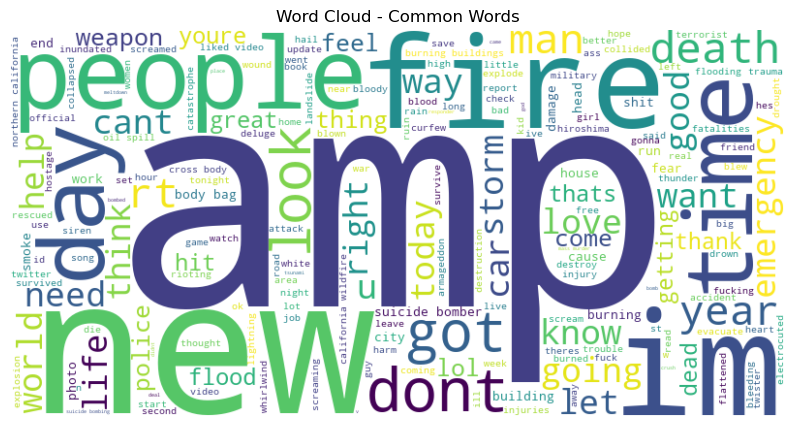

In [758]:
text_combined = ' '.join(train_df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Common Words')
plt.show()

Hãy phân tích sâu hơn về các từ phổ biến. Đâu là những từ phổ biến cho một tweet disaster và non-disaster? Dưới đây là biểu đồ cột thể hiện số lượng các từ phổ biến trong các disaster tweet và non-disaster tweet

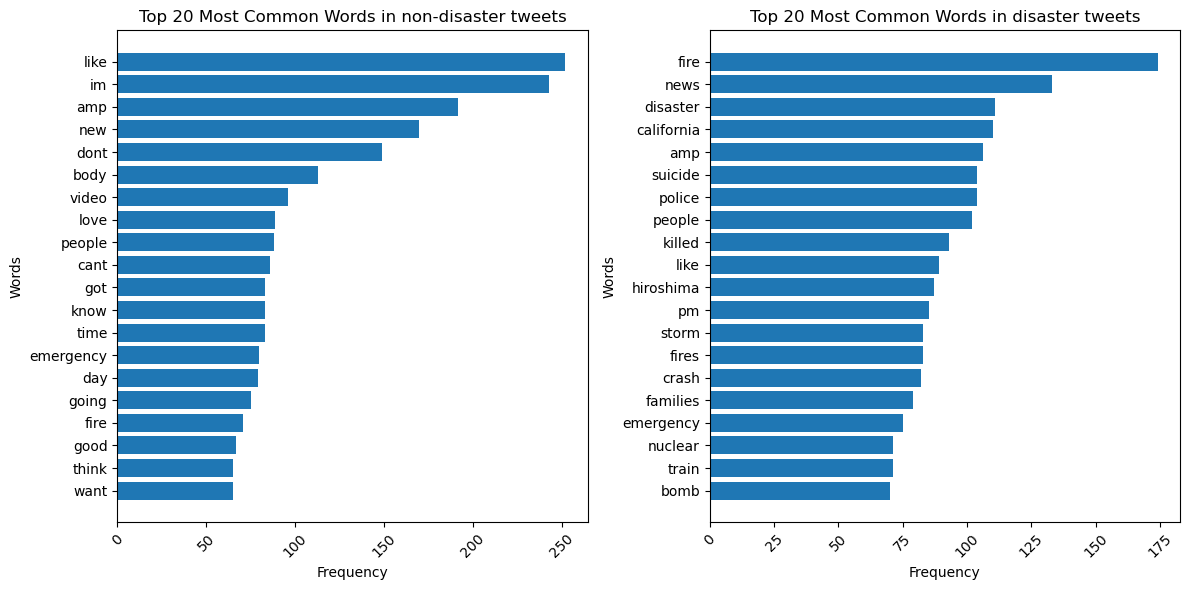

In [759]:
import matplotlib.pyplot as plt
from collections import Counter

# Tách các từ trong cột "text" với target = 0
words_0 = train_df['text'][train_df["target"] == 0].str.split()
all_words_0 = [word for sublist in words_0 for word in sublist]
word_counts_0 = Counter(all_words_0)
top_20_words_0 = word_counts_0.most_common(20)
word_list_0, word_count_0 = zip(*top_20_words_0)
word_list_0, word_count_0 = zip(*sorted(zip(word_list_0, word_count_0), key=lambda x: x[1], reverse=False))


# Tách các từ trong cột "text" với target = 1
words_1 = train_df['text'][train_df["target"] == 1].str.split()
all_words_1 = [word for sublist in words_1 for word in sublist]
word_counts_1 = Counter(all_words_1)
top_20_words_1 = word_counts_1.most_common(20)
word_list_1, word_count_1 = zip(*top_20_words_1)
word_list_1, word_count_1 = zip(*sorted(zip(word_list_1, word_count_1), key=lambda x: x[1], reverse=False))

# Vẽ biểu đồ subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ cho target = 0
axes[0].barh(word_list_0, word_count_0)
axes[0].set_title('Top 20 Most Common Words in non-disaster tweets')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ cho target = 1
axes[1].barh(word_list_1, word_count_1)
axes[1].set_title('Top 20 Most Common Words in disaster tweets')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Kết quả nhìn có vẻ khá hợp lý khi các từ phổ biến trong các tweet non-disaster là các danh từ, động từ thường dùng trong cuộc sống hàng ngày như like, im, amp, new. Trong khi các từ trong disaster tweet mang nghĩa nguy hiểm, tiêu cực như fire, disaster,...

Hãy nhìn xem đối với các 2-grams thì như thế nào?

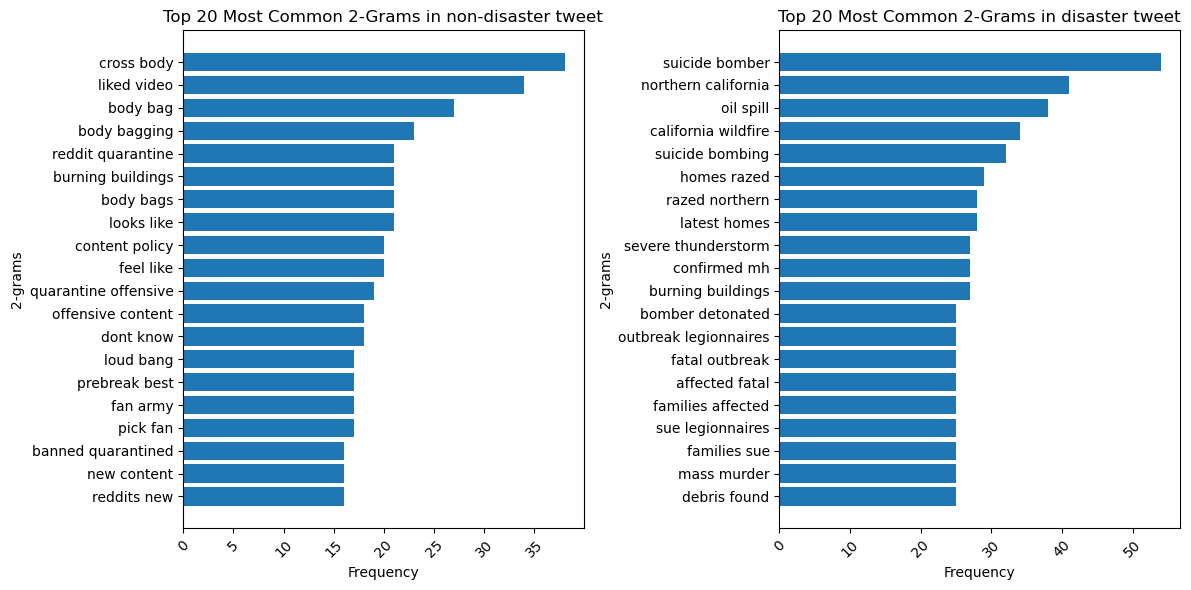

In [760]:
import matplotlib.pyplot as plt
from collections import Counter

# Tách các từ trong cột "text" với target = 0 thành 2-gram
words_0 = train_df['text'][train_df["target"] == 0].str.split()
two_grams_0 = [word for sublist in words_0 for word in zip(sublist[:-1], sublist[1:])]
all_two_grams_0 = [' '.join(gram) for gram in two_grams_0]
two_gram_counts_0 = Counter(all_two_grams_0)
top_20_two_grams_0 = two_gram_counts_0.most_common(20)
two_gram_list_0, two_gram_count_0 = zip(*top_20_two_grams_0)
two_gram_list_0, two_gram_count_0 = zip(*sorted(zip(two_gram_list_0, two_gram_count_0), key=lambda x: x[1], reverse=False))

# Tách các từ trong cột "text" với target = 1 thành 2-gram
words_1 = train_df['text'][train_df["target"] == 1].str.split()
two_grams_1 = [word for sublist in words_1 for word in zip(sublist[:-1], sublist[1:])]
all_two_grams_1 = [' '.join(gram) for gram in two_grams_1]
two_gram_counts_1 = Counter(all_two_grams_1)
top_20_two_grams_1 = two_gram_counts_1.most_common(20)
two_gram_list_1, two_gram_count_1 = zip(*top_20_two_grams_1)
two_gram_list_1, two_gram_count_1 = zip(*sorted(zip(two_gram_list_1, two_gram_count_1), key=lambda x: x[1], reverse=False))

# Vẽ biểu đồ subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ cho target = 0
axes[0].barh(two_gram_list_0, two_gram_count_0)
axes[0].set_title('Top 20 Most Common 2-Grams in non-disaster tweet')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('2-grams')
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ cho target = 1
axes[1].barh(two_gram_list_1, two_gram_count_1)
axes[1].set_title('Top 20 Most Common 2-Grams in disaster tweet')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('2-grams')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Hầu hết các 2-grams về thảm họa đều có chứa tên thảm họa ở trong như 'bomber', 'oil spill', 'thunderstorm'. Ngoài ra những câu 2-grams có chứa 'califonia' có xu hướng là disaster, ta cũng đã gặp từ 'califonia' ở biểu đồ các từ phổ biến của disaster tweet ở phía trên.

In [761]:
train_df.to_csv('train_preprocessing.csv')
test_df.to_csv('test_preprocessing.csv')